# Strategy for parameter tuning
1. Kernel size: larger kernel, more blurred
2. filter iterations

## Filters
1. Gaussian 
2. Meadian
3. Bilateral

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread("img.png")

(1000, 707, 3)


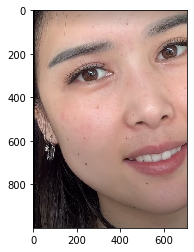

In [3]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

<h2> built in filters in cv2</h2>
<ol>
    <li> cv2.blur(src, ksize[, dst[, anchor[, borderType]]]) <br>
        simple averaging</li>
    <li> cv2.medianBlur(	src, ksize[, dst]	)<br>
        use median instead of gaussian, kernel size must be a positive odd integer.</li>
    <li> cv2.GaussianBlur(	src, ksize, sigmaX[, dst[, sigmaY[, borderType]]]	)<br>
        simgaX, sigmaY: Gaussian kernel standard deviation<br>
        dst=0: 	output image of the same size and type as src.<br>
        preserves more details</li>
        
    
    


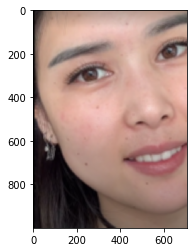

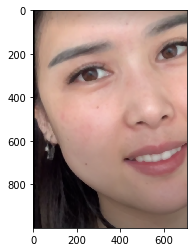

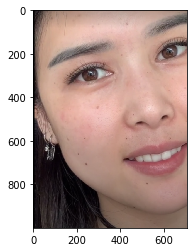

In [4]:
img_blurred = cv2.blur(img,(11,11))
plt.imshow(img_blurred)
img_median = cv2.medianBlur(img,11)
plt.figure()
plt.imshow(img_median)
img_gaussian = cv2.GaussianBlur(img,(5,5),0) 
plt.figure()
plt.imshow(img_gaussian)

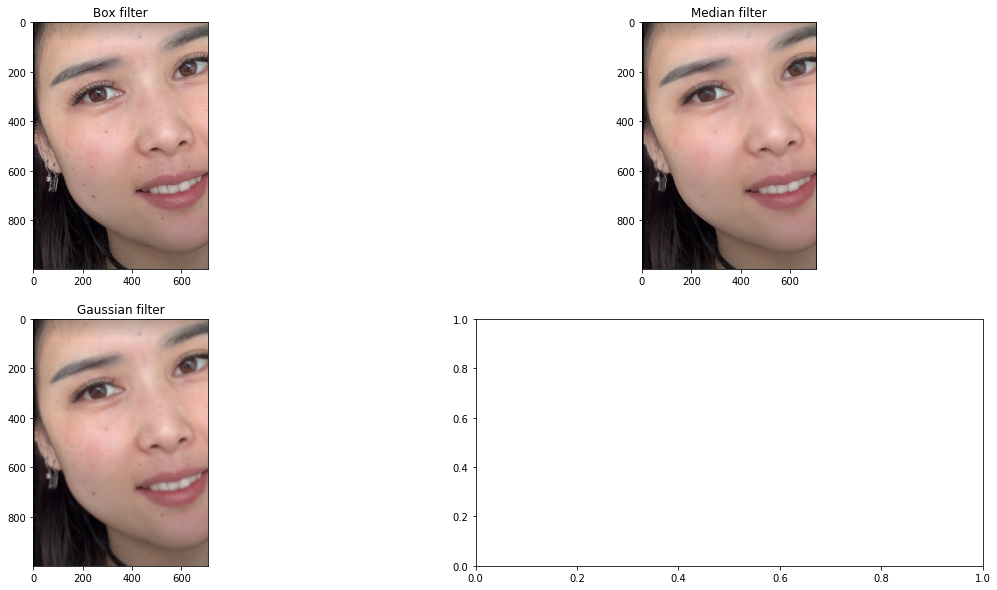

In [5]:
#try iterate through the filters using small kernels multiple times
iteration = 10
kernel_size = 5
img_box_iter = img
img_median_iter = img
img_gaussian_iter = img

for _ in range(iteration):
    img_box_iter = cv2.blur(img,(kernel_size,kernel_size))
    img_median_iter=cv2.medianBlur(img_median_iter,kernel_size)
    img_gaussian_iter = cv2.GaussianBlur(img_gaussian_iter,(kernel_size,kernel_size),0) 

    
    
#plot results
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(img_box_iter)
ax1.title.set_text('Box filter')
ax2.imshow(img_median_iter)
ax2.title.set_text('Median filter')
ax3.imshow(img_gaussian_iter)
ax3.title.set_text('Gaussian filter')

__Result__ : Median filter gives better noise reduction  - feature blurring balance

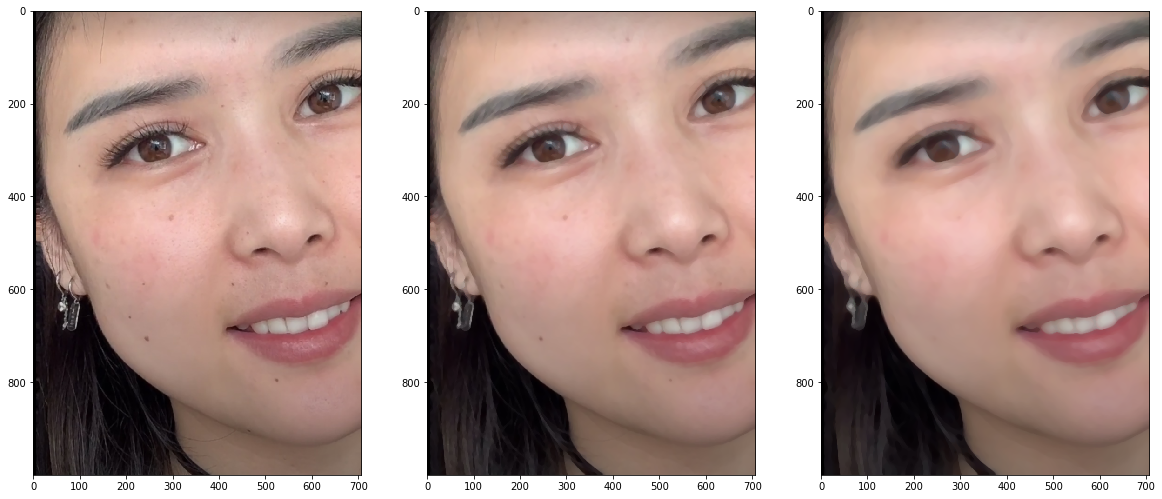

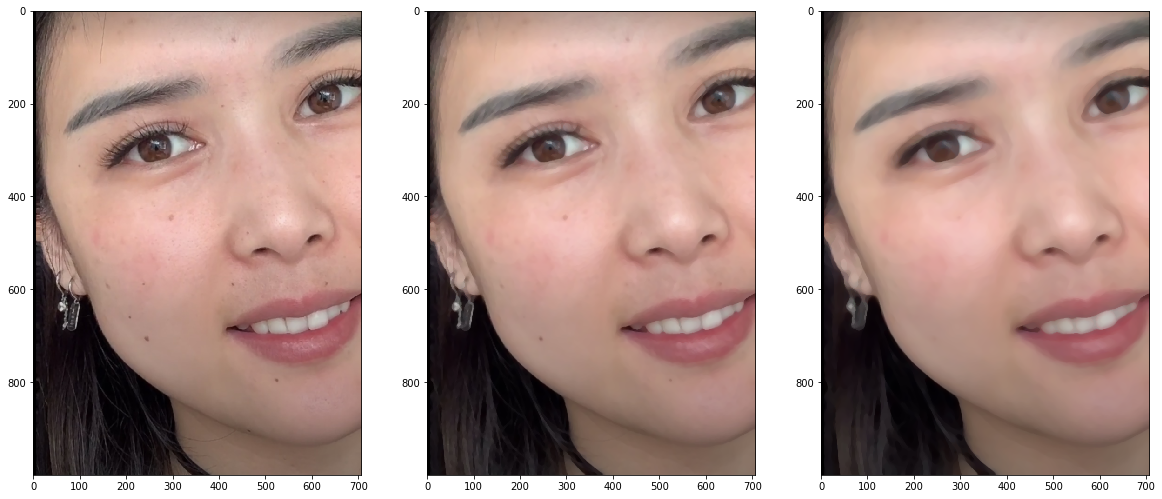

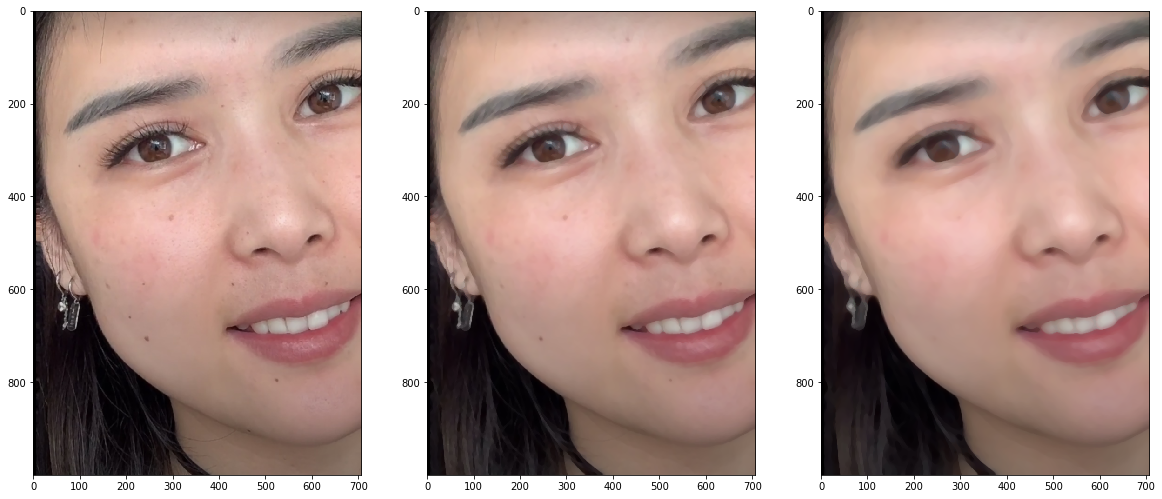

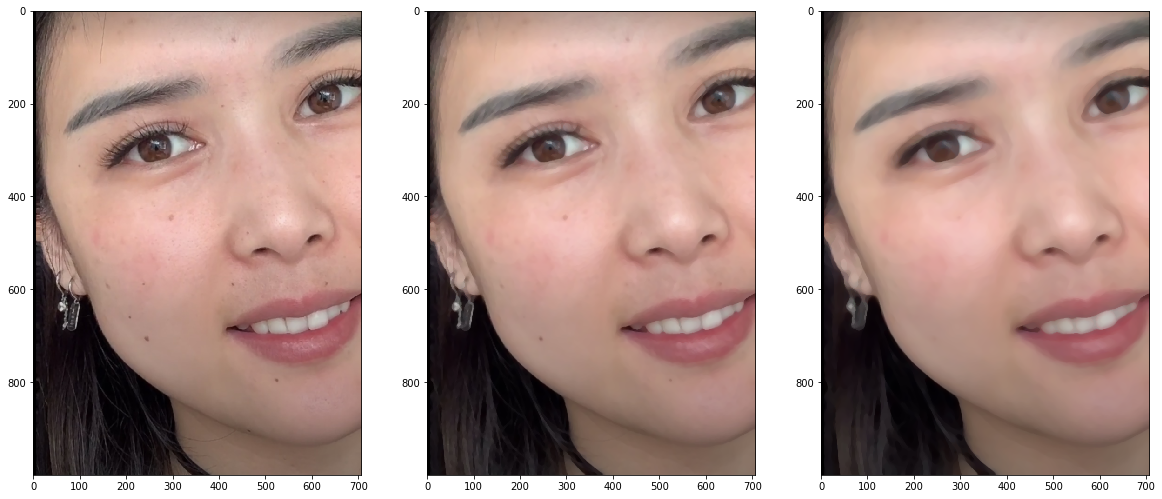

In [6]:
#explore parameters for median blur

kernel_size = [3,5,7,9]
iterations = [2,4,6]
for i in range(len(kernel_size)):
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax = [ax1, ax2, ax3]
    img_median_iter = img
    for i, iteration in enumerate(iterations):
        for _ in range(iteration):
            img_median_iter=cv2.medianBlur(img_median_iter,kernel_size[i])
        cur_ax = ax[i]    
        cur_ax.imshow(img_median_iter)
    
    

__Result__ : we can get ok result using 4-6 iterations with kernel size of 3-9. But edge is strongly blurred, which is unwanted for skin-retouching. We will resolve this issue in the following sections.

<h1> Bilateral Filter </h1>
<a href = "https://people.csail.mit.edu/sparis/bf_course/course_notes.pdf"> Bilateral Filter MIT lecture notes </a><br>
    
<a href="https://youtu.be/S9Cd_VgegZE"> The following notes are taken from Siggraph 2008 Tutorial </a> <br>

Both box and gaussian filters blur edges. A class of filtering techniques, called edge-preserving noise reduction get around this problem. Bilateral Filter is one of them.bilateralFilter can reduce unwanted noise very well while keeping edges fairly sharp. However, it is very slow compared to most filters.<br>

<h2> Broader idea</h2>
Split an image into:<br>
__structure__ : large scale features, smoothed image, but edge are preserved <br>
__texture__ : small scale feature

<h2> Definition </h2>
$$
B F[I]_{\mathrm{p}}=\frac{1}{W_{p}} \sum_{q \in S} G_{\sigma_{i}}(\|\mathbf{p}-\mathbf{q}\|) G_{\sigma_{F}}\left(\left|I_{p}-I_{q}\right|\right) I_{q}
$$
Space term: similar to gaussian
$$
G_{\sigma_{i}}(\|\mathbf{p}-\mathbf{q}\|)
$$
intensity term: if the two pixels are too different in intensity, they are on edge and should not be blurred.
$$
G_{\sigma_{F}}\left(\left|I_{p}-I_{q}\right|\right)
$$
For color image, color difference is calculated
$$
G_{\sigma_{F}}\left(\left|C_{p}-C_{q}\right|\right)
$$
$\sigma_s$: spatial extent of the kernel, size of the considered neighborhood <br>
$\sigma_r$: "minimum amplitude of an edge <br>
__overall result__ : apply gaussian only on continuous (not cross edge) regions, pixels across the edge have low influence on the averaging

<h2> cv2 built-in bilateralFilter </h2>
cv2.bilateralFilter(	src, d, sigmaColor, sigmaSpace[, dst[, borderType]]	)<br>

__d__	proportional to image size. Diameter of each pixel neighborhood that is used during filtering. If it is non-positive, it is computed from sigmaSpace.<br>
__sigmaColor__	Filter sigma in the color space. A larger value of the parameter means that farther colors within the pixel neighborhood (see sigmaSpace) will be mixed together, resulting in larger areas of semi-equal color.<br>
__sigmaSpace__	proportional to edge amplitude, eg. mean or median of image amplitude. Filter sigma in the coordinate space. A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough (see sigmaColor ). When d>0, it specifies the neighborhood size regardless of sigmaSpace. Otherwise, d is proportional to sigmaSpace.<br>

<h3> Application Notes </h3>
<ol>
    <li> Range sigma:
        <ol>
            <li> too low: stricter about what's considered an edge, only average pixels that are very close in value. Some noise may preserve</li>
            <li> too high: blur edges</li>
        </ol>
    </li>
    <li> Spatial sigma:
        <ol>
            <li>Normally use small spatial sigma (eg.7*7 window)</li>
        </ol>
    </li>
    <li> Impulse noise
        <ol>
            <li> Definition: high amplitide noise at few pixels</li>
            <li> Problem: the noise is treated as a strong edge</li>
            <li> Solution: pre-filter with median filter, then use filtered image M as reference for range Gaussians
                $$
G_{\sigma_{F}}\left(\left|M_{p}-I_{q}\right|\right)
$$
            </li>
        </ol>
</ol>

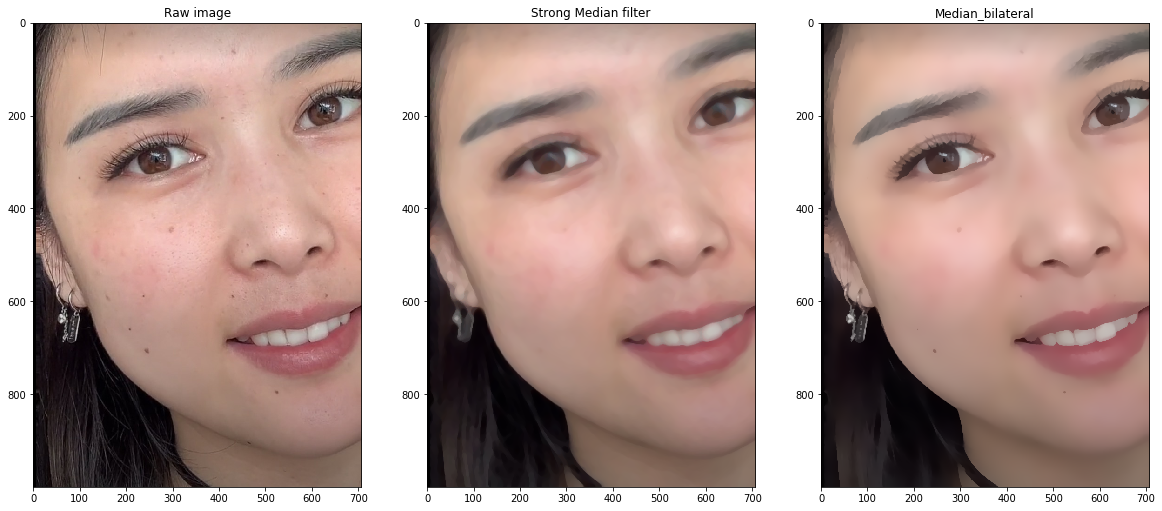

In [7]:
#chose median filter with size 5 to prevent over blurring of edges
img_median = cv2.medianBlur(img,5)
#use bilateral filter twice, filter is chosen to be several % of the image size
img_bilateral = cv2.bilateralFilter(img_median, 50,30,7)
img_bilateral = cv2.bilateralFilter(img_bilateral, 50,30,7)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
#plot raw image
ax1.imshow(img)
#plot strongly filtered image from previous iteration step
ax2.imshow(img_median_iter)
#plot current median_bilateral image
ax3.imshow(img_bilateral)
ax1.title.set_text('Raw image')
ax2.title.set_text('Strong Median filter')
ax3.title.set_text('Median_bilateral')

__Result__ : use median filter to blur out impulse noise, then use bilateral filter gives nice noise reduction while preserving edges of major features. This is obvious when compared to strongly filtered image using median filter.

<h2> Other applications of bilateral filter  - FUNNNN! </h2>
<h3> Tone Mapping </h3>
Deal with dynamic range of picture. <br>
Related:<br>
Multiple exposure photography: HDR, merge multiple photos with different exposure <br>

__Tone Mapping__ :  input high dynamic range image, and we want to reduce dynamic range for display<br>
Naive technique will be simply use $X^ \gamma$ where $ \gamma<1$  Applied on contrast of intensity component (in contrast to color) of ths picture.

about human percetion system: we are sensitive to local but less to global contrast. Then, we can separate the image into:<br>

__high frequency__ : capture local contrast, preserve contrast here, psudo texture
__low frequency__ : global contrast, we can reduce conrtast here, most contrast issue comes from this region too. psudo illumination __problem around strong edges__ : can be solved by bilateral filter

<h4> Bilateral filter for contrast reduction </h4>

__Process__:

<ol>
    <li> Input HDR image </li>
    <li> Separate into intensity and color domain</li>
    <li> Bilateral filter in log domain: large scale contrast. We use log because we are sensitive to multiplicative contrast (10-20 similar to 100-200). Spatial sigma 2-5% of image size (comparing to 7 pixels for noise reduction), range sigma 0.4 in log10.</li>
    <li> residual: Detail = log intensity - large scale </li>
    <li> output = reduce contrast(large scale) + detail + color</li>
</ol>

__contrast reduction in log domain__:
1. $largeRange = max(inLogLarge) - min(inLogLarge)$ <br>
2. scale factor $k = log_{10}(10)/largeRange$ <br>
3. normalize so that biggest value is 0 in log <br>
4. $outLog = inLogDetail + inLogLarge*k-max(inLogLarge)$ <br>
   
__Denoising vs. tone mapping__:
1. denosing: decompose to noise + signal, throw aray noise, keep signal. small kernal 
2. Tone mapping: decompose to large scale + detail, preserve detail, compress large scale. large kernel, because detail = high+medium frequency. Computationally expensive.  

__properties__ :
1. Bilater filter goes across thin lines because we use relatively large kernel
2. spatial sigma not very important, range sigma quite important
3. critical to use log domain for range
4. liminance computation is not critical but has influence

<h3> Relighting and texture editing </h3>
main assumption:
$$image \;/\; illumination = texture $$

## only apply to skin color

In [8]:
result_show=img_median_iter.copy()
#result_show = cv2.cvtColor(result_show, cv2.COLOR_RGB2HSV)
#img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
# skin_color detection
# source https://www.cnblogs.com/demodashi/p/9437559.html
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
(_h, _s, _v) = cv2.split(hsv) # split to h,s v channel
skin3 = np.zeros(_h.shape, dtype=np.uint8)  # create new array with shape of original image
(x, y) = _h.shape # obtain original shape

#skin_color filter
# find pixels with h,s,v within range, set to 255, other to 0
for i in  range(0, x):
    for j in  range(0, y):
        #in range of skin color
        if (_h[i][j] >  5) and (_h[i][j] <  70) and (_s[i][j] >  18) and (_s[i][j] <  255) and (_v[i][j] >  50) and (_v[i][j] <  255):
            skin3[i][j] =  255
            #result[i][j]=img[i][j]
        #not in range of skin color
        else:
            skin3[i][j] =  0
            result_show[i][j]=img[i][j]
#cv2.imshow('img', img)
#cv2.imshow('img' +  " Skin3 HSV", skin3)
#cv2.imwrite("skin.png",skin3)
#import os
#os.system("open skin.png")
#cv2.imwrite("compare2.png",cv2.hconcat([img,result_show]))
#os.system("open compare2.png")

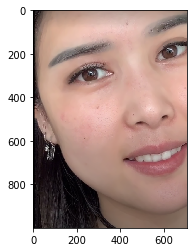

In [10]:
plt.imshow(result_show)

In [11]:
skin3.shape

(1000, 707)

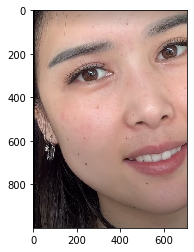

In [12]:
plt.imshow(img)